In [1]:
import os, sys
currentdir = os.path.dirname(os.getcwd())
sys.path.append(currentdir)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utilities.plotlib as pltlib 
import itertools

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
DIR = "C:<save folder"

df_nn = pd.read_pickle('results_FFN.pkl')
df_nn = df_nn[df_nn.loc[:, 'test_passed'] == True]

df_rnn = pd.read_pickle('results_RNN.pkl')
df_rnn = df_rnn[df_rnn.loc[:, 'test_passed'] == True]

df_combined = pd.read_pickle('results_combined.pkl')
df_combined = df_combined[df_combined.loc[:, 'test_passed'] == True]

network_results = [df_nn, df_rnn, df_combined]
labels = ['FFN', 'RNN', 'FFN + RNN']

for df in network_results:
    df.history_training_data = df.history_training_data.apply(lambda x:np.array(x))
    df.history_test_data = df.history_test_data.apply(lambda x:np.array(x))

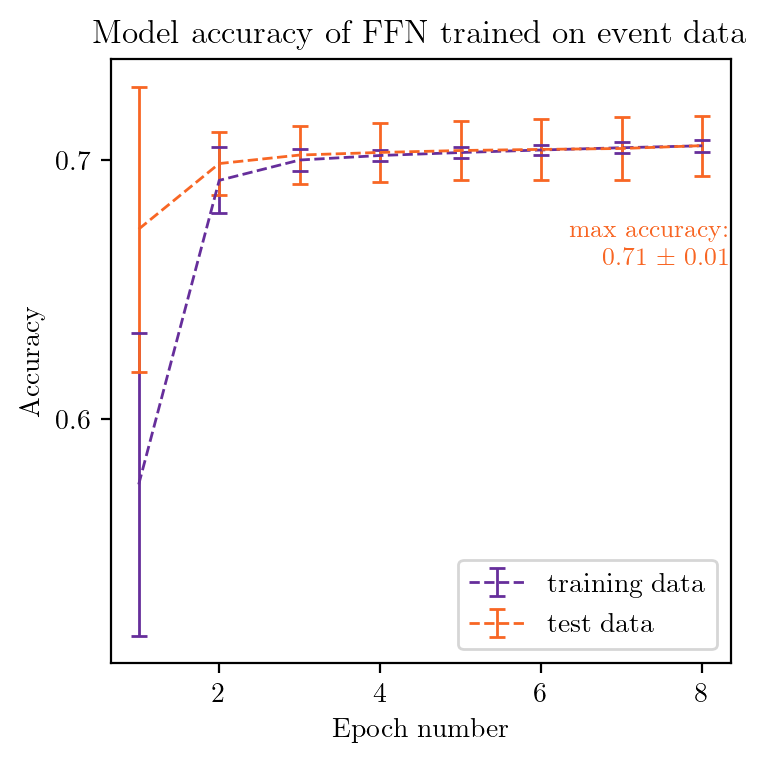

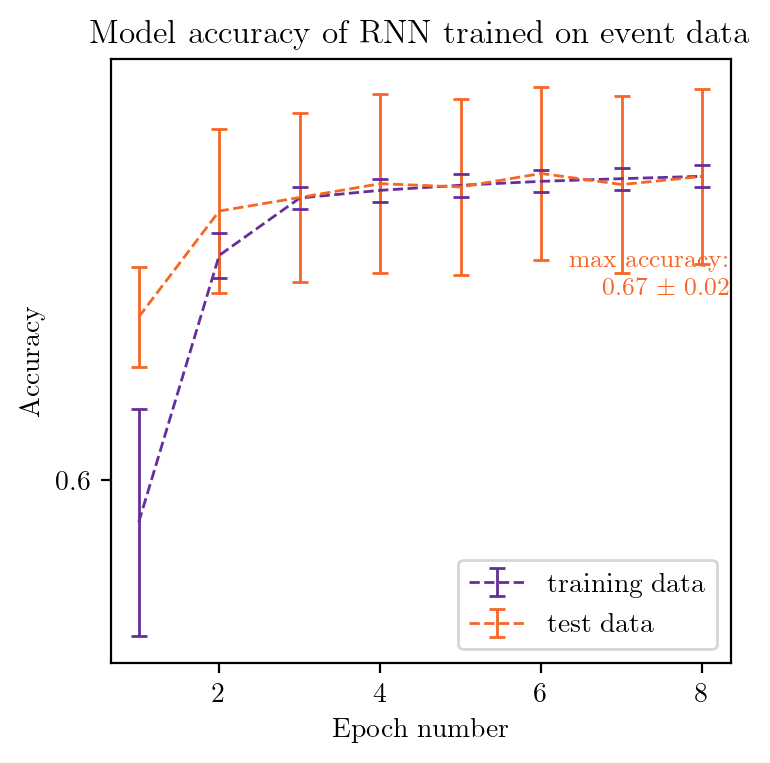

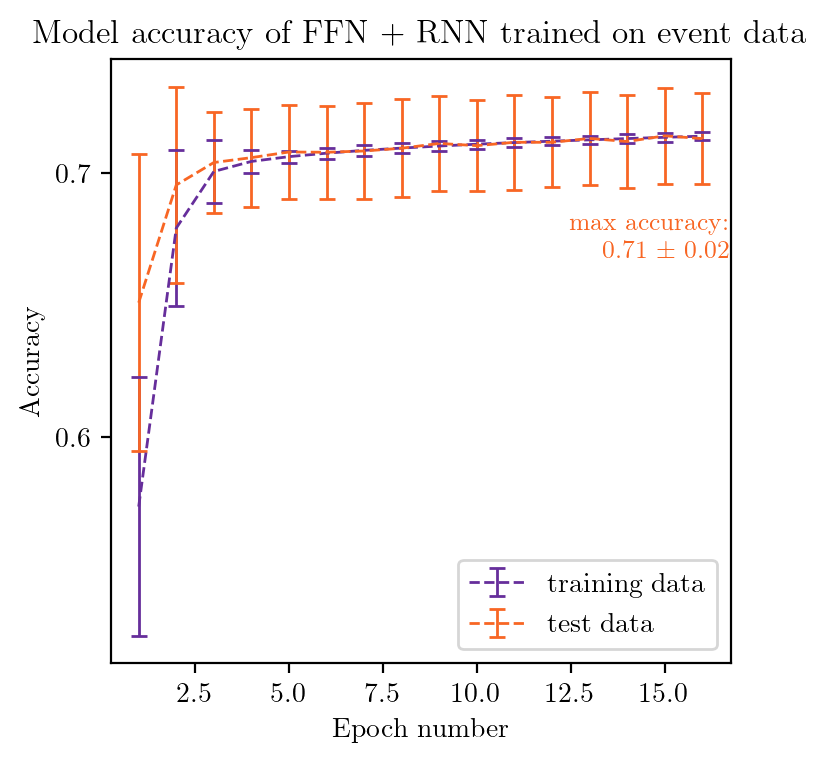

In [3]:
for name, df in zip(labels, network_results):
    params_history = {'title' : ('Model accuracy of {} trained on event data'.format(name)),
                'x_axis' : 'Epoch number',
                'y_axis' : 'Accuracy',
                'legend' : ['training data', 'test data'],
                'figsize' : (4, 4),
                'dpi' : 200,
                'colors' : ['#662E9B', '#F86624'],
                'full_y' : False}
    
    history_training_data_mean = np.mean(df.history_training_data, axis=0)
    history_test_data_mean = np.mean(df.history_test_data, axis=0)
    
    history_training_data_std = np.std(df.history_training_data.values, axis=0)
    history_test_data_std = np.std(df.history_test_data.values, axis=0)
    
    history_error_bars = [history_training_data_std, history_test_data_std]
    
    fig1 = pltlib.training_history_plot(history_training_data_mean,
                              history_test_data_mean,
                              params_history,
                              history_error_bars)
    
#     fig1.savefig(DIR + 'training_history_{}.pdf'.format(name))

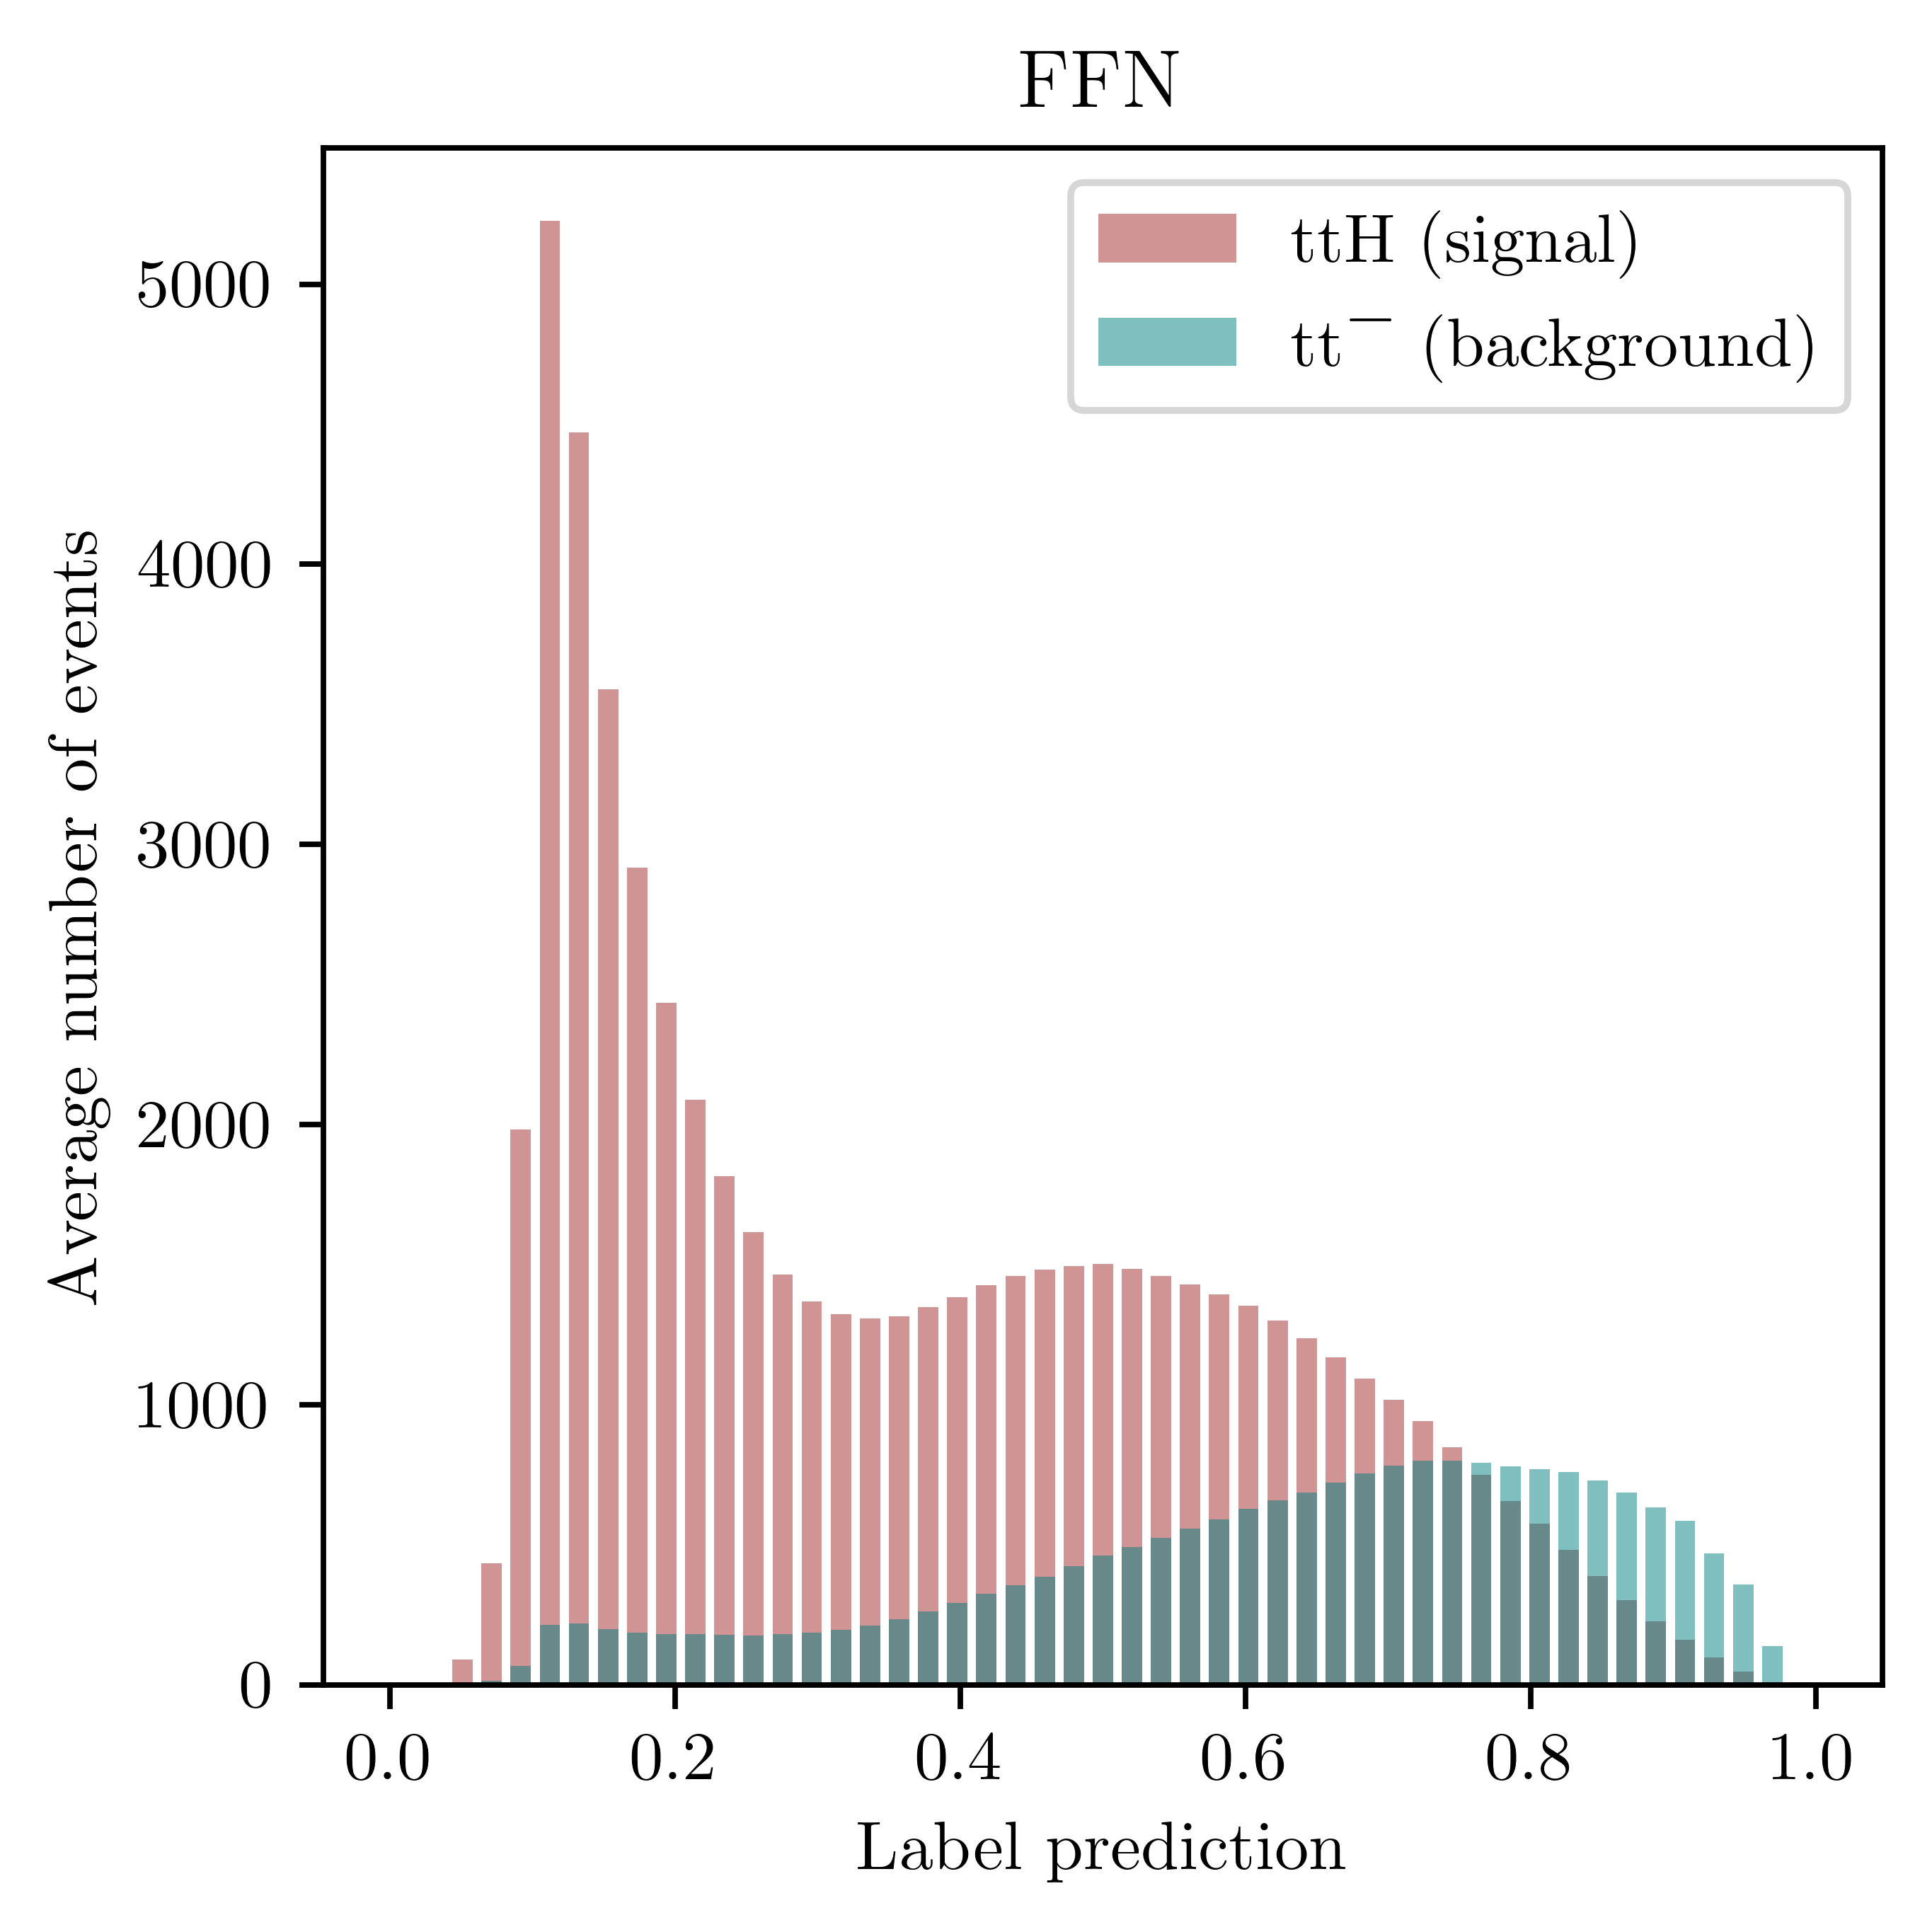

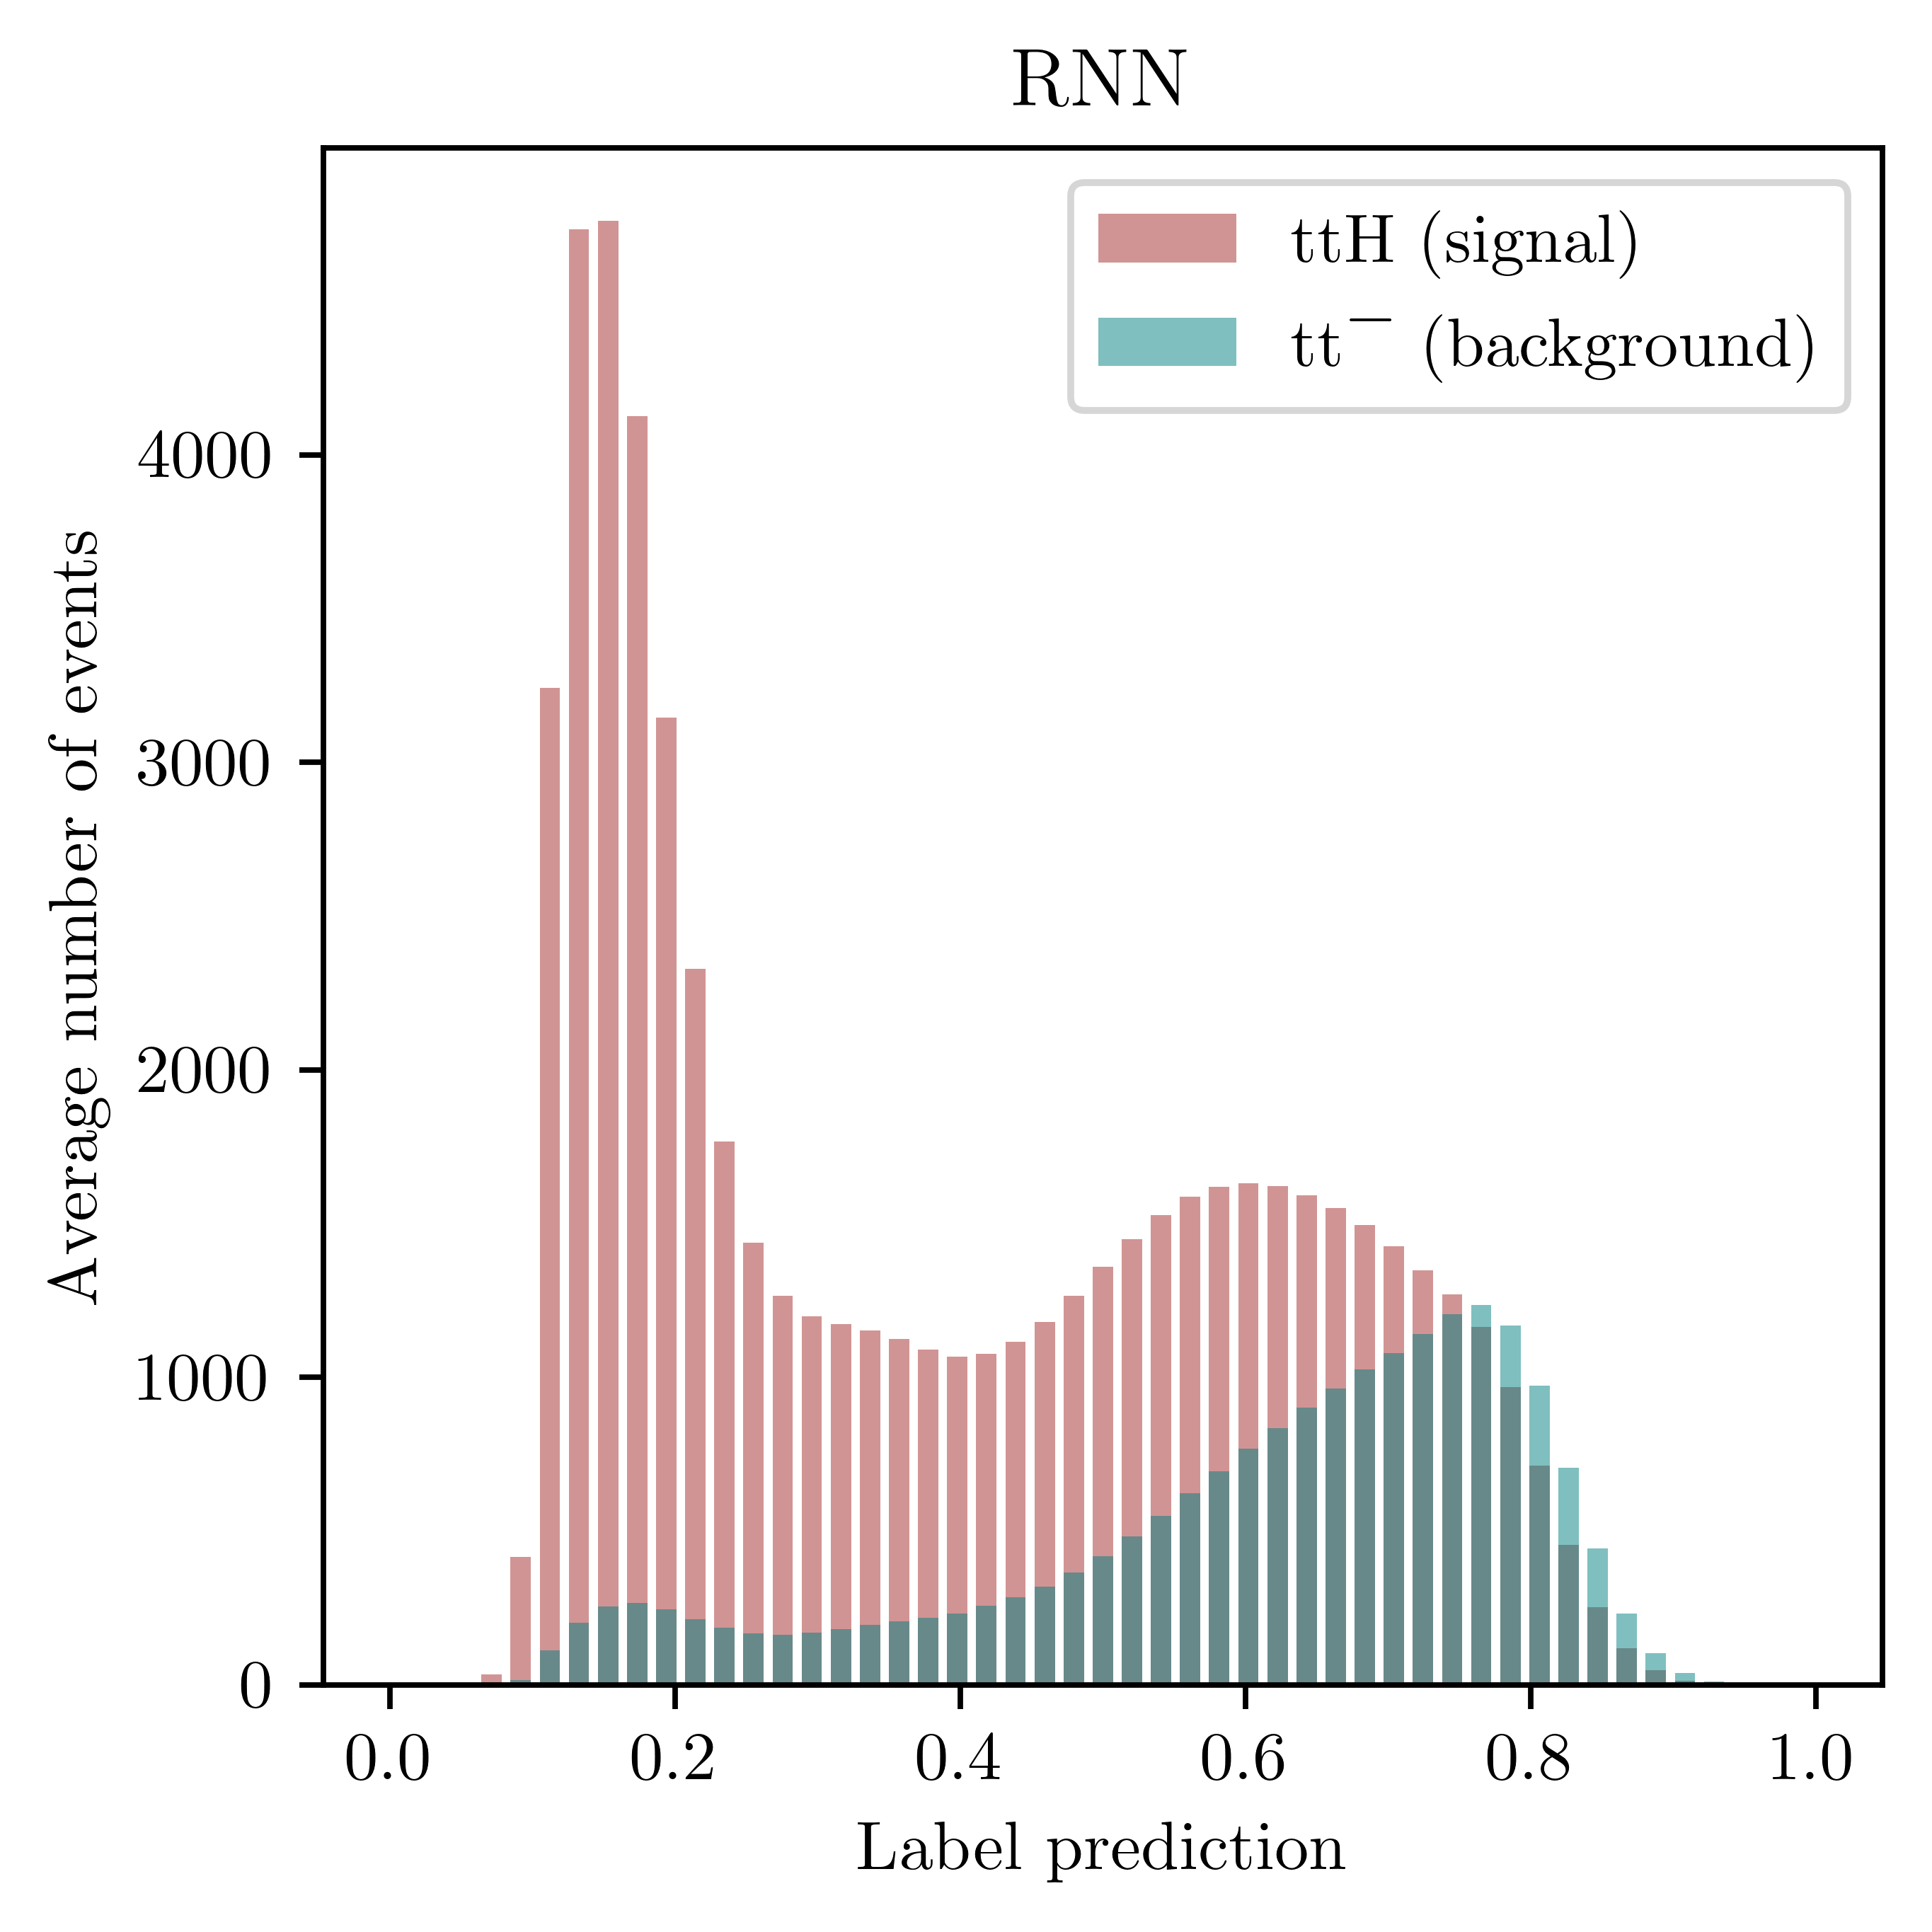

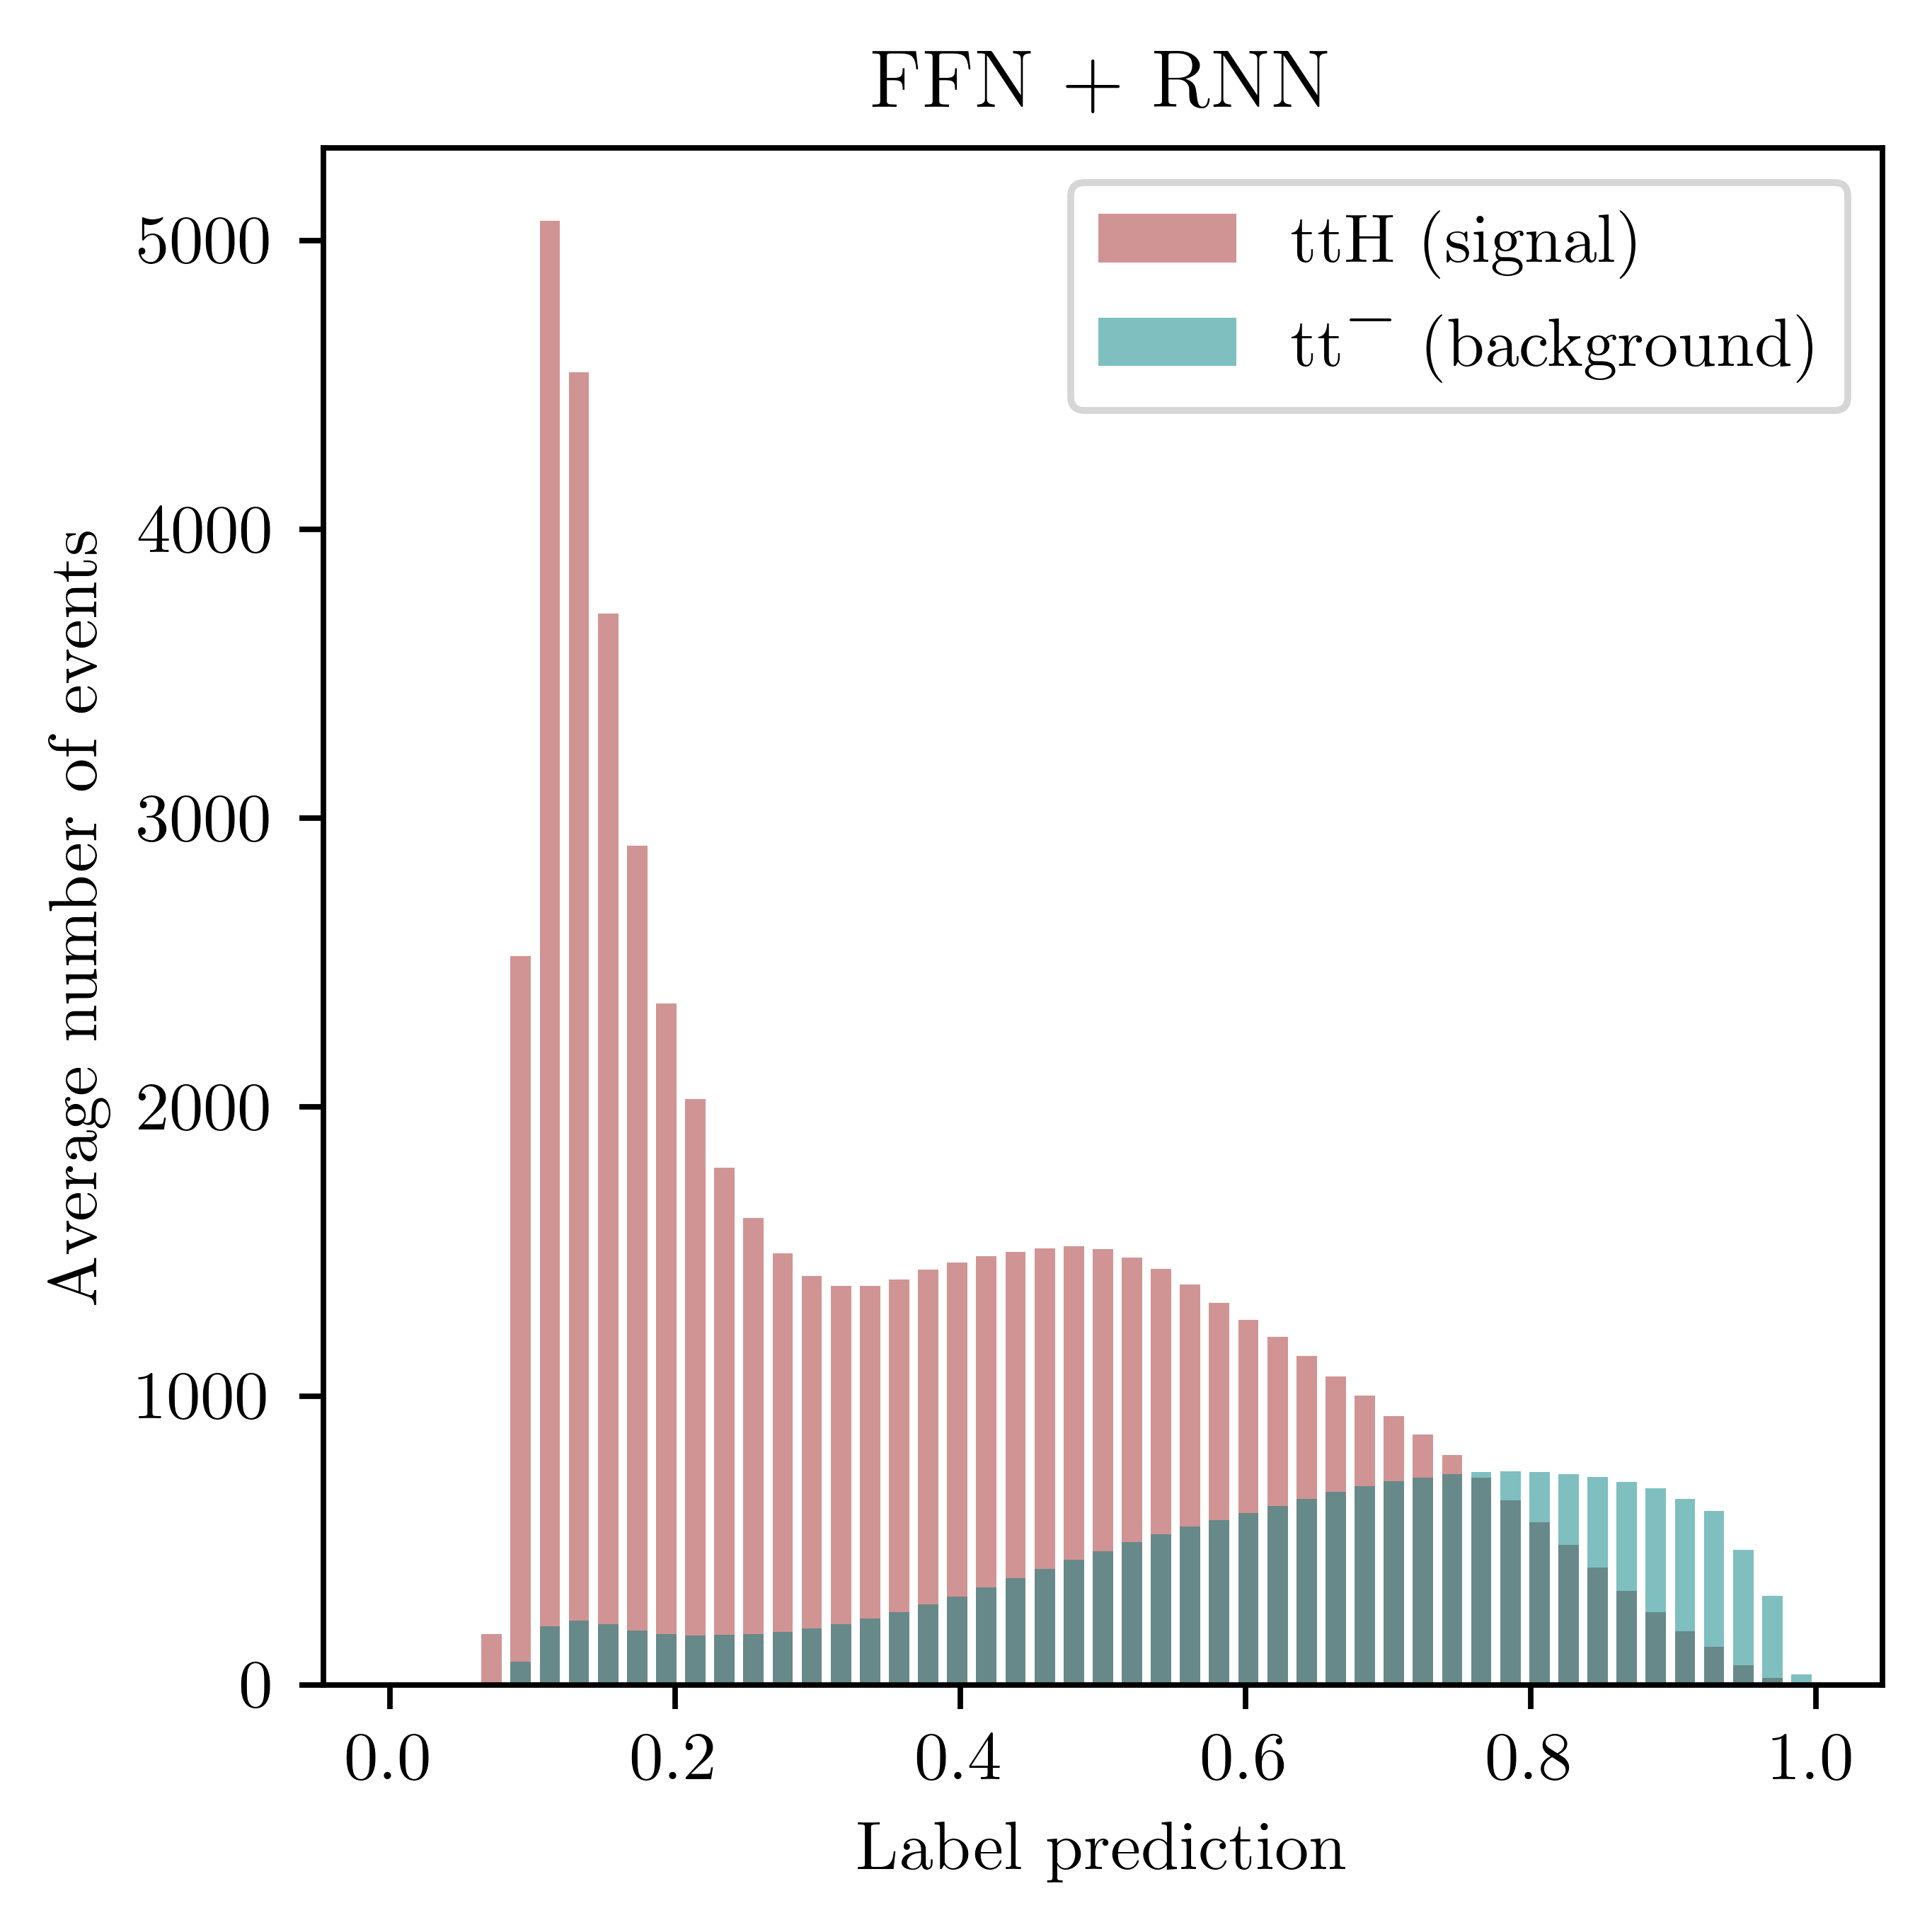

In [32]:
for name, df in zip(labels, network_results):
    fig2, ax2 = plt.subplots(figsize=(4,4), dpi=700)
    background_bin_vals = np.mean(df.background_bin_vals, axis=0)
    signal_bin_vals = np.mean(df.signal_bin_vals, axis=0)
    background_bin_err = np.std(df.background_bin_vals.values, axis=0)
    signal_bin_err = np.std(df.signal_bin_vals.values, axis=0)

    bin_edges = df.bins.iloc[0]
    bin_width = 0.7 * (bin_edges[1] - bin_edges[0])
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    colours = ['brown', 'teal']
    
    ax2.bar(bin_centers, background_bin_vals, align='center', width=bin_width, alpha=0.5,
           label='ttH (signal)', color=colours[0])
    ax2.bar(bin_centers, signal_bin_vals, align='center', width=bin_width, alpha=0.5,
           label='tt¯ (background)', color=colours[1])
    ax2.set_xlabel('Label prediction')
    ax2.set_ylabel('Average number of events')
    ax2.set_title(name)
    ax2.legend()
    fig2.tight_layout()
#     fig2.savefig(DIR + '{}_discriminator_plot.pdf'.format(name))
    

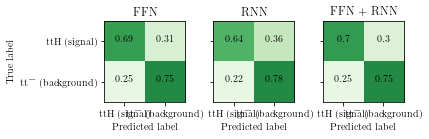

In [21]:
class_names =  ['ttH (signal)', 'tt¯ (background)']
cm_list = []

for df in network_results:
    cm_list += [np.mean(df.confusion_matrix, axis=0)]

fig3 = pltlib.mulit_confusion_matrix(cm_list, class_names, labels, figsize=(4, 4), dpi=200)
fig3.tight_layout()
# fig3.savefig(DIR + 'confusion_matrices.pdf')

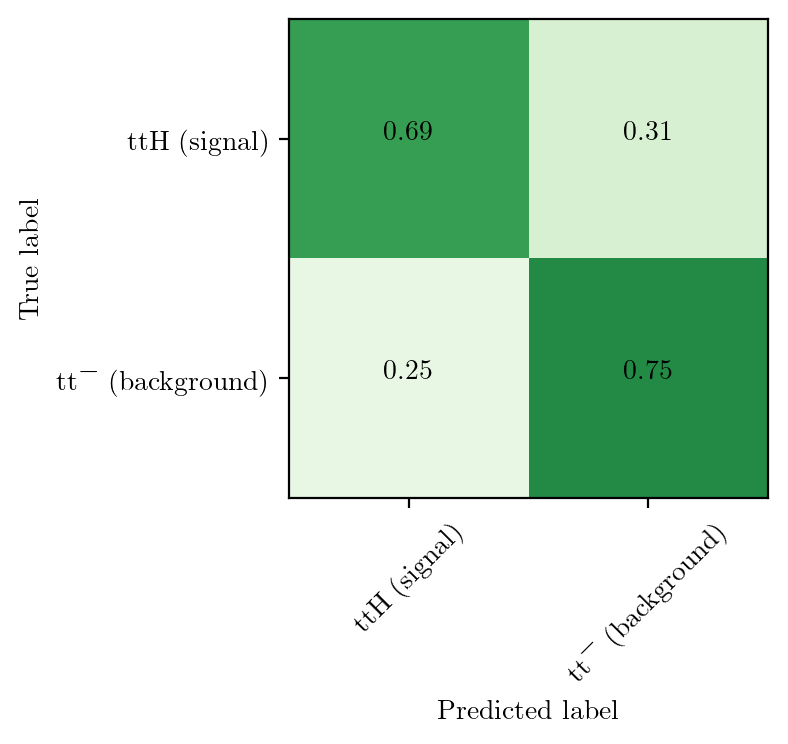

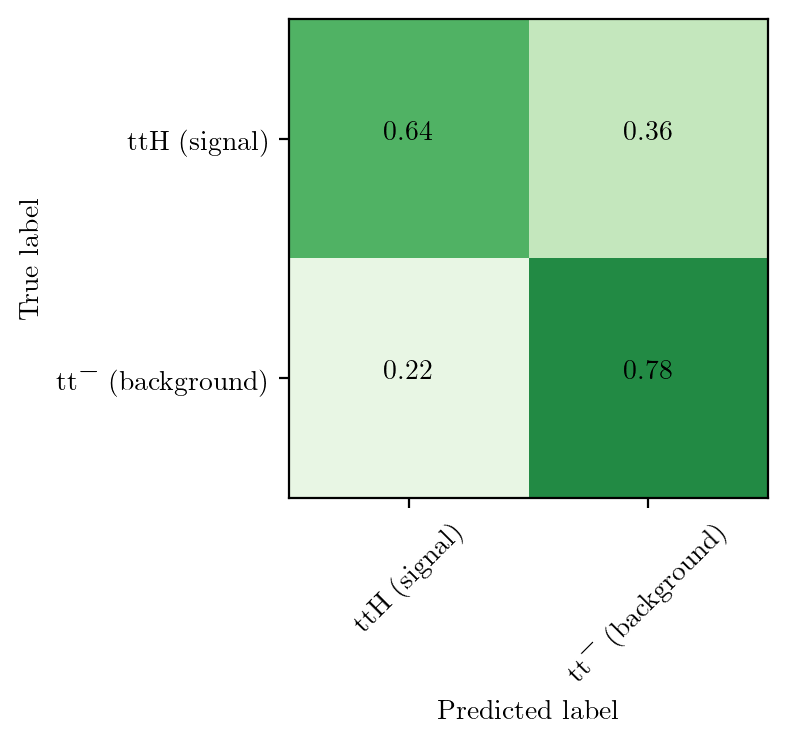

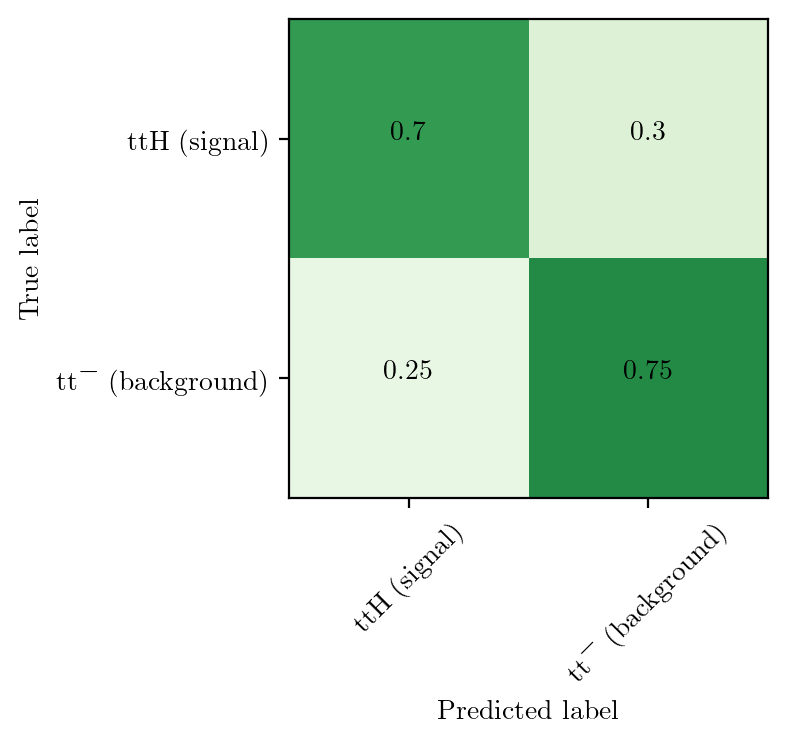

In [27]:
for name, cm in zip(labels, cm_list):
    params_cm = {'title' : (''),
             'x_axis' : 'Predicted label',
             'y_axis' : 'True label',
             'class_names' : ['ttH (signal)', 'tt¯ (background)'],
             'figsize' : (4, 4),
             'dpi' : 200,
             'colourbar' : False}
    Fig = pltlib.confusion_matrix(cm, params_cm)
    Fig.tight_layout()
    Fig.savefig(DIR + '{}_confusion_matrix.pdf'.format(name))
    

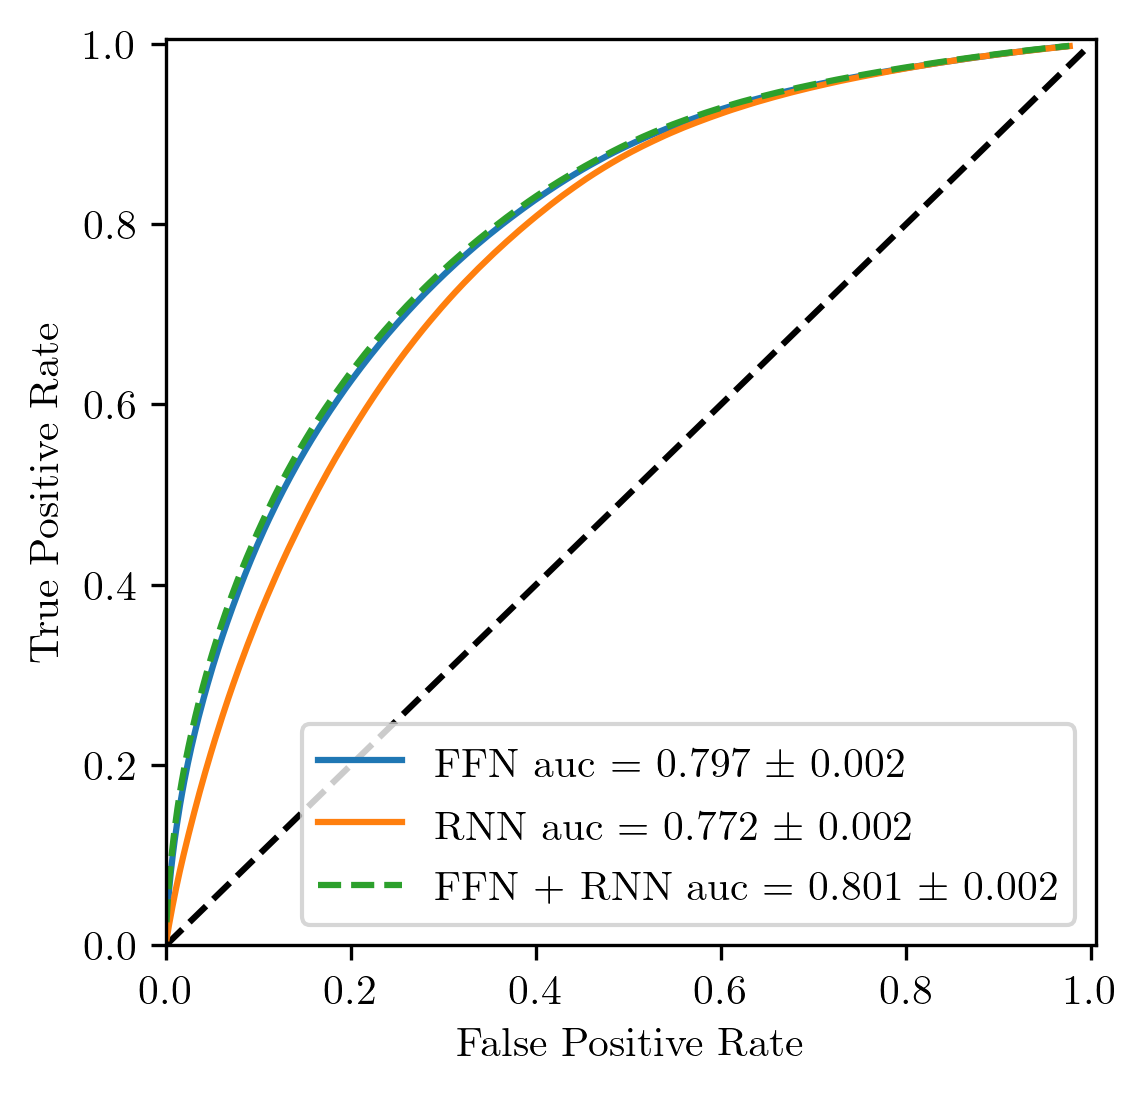

In [6]:
fig4, ax4 = plt.subplots(figsize=(4,4), dpi=300)
ax4.plot([0, 1], [0, 1], 'k--')
    
ax4.set_xlim([0.0, 1.005])
ax4.set_ylim([0.0, 1.005])
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
linestyles = ['-', '-', '--']

for name, df, ls in zip(labels, network_results, linestyles):
    mean_fpr = np.mean(df.roc_fpr_vals, axis=0)
    mean_tpr = np.mean(df.roc_tpr_vals, axis=0)
    
    mean_auc = df.roc_auc.mean()
    std_auc = df.roc_auc.std()
    
    label = '{} auc = {:.3f} \u00B1 {:.3f}'.format(name, mean_auc, std_auc)
    ax4.plot(mean_fpr, mean_tpr, ls, label=label)

ax4.legend()
# fig4.savefig(DIR + 'roc_curves.pdf')

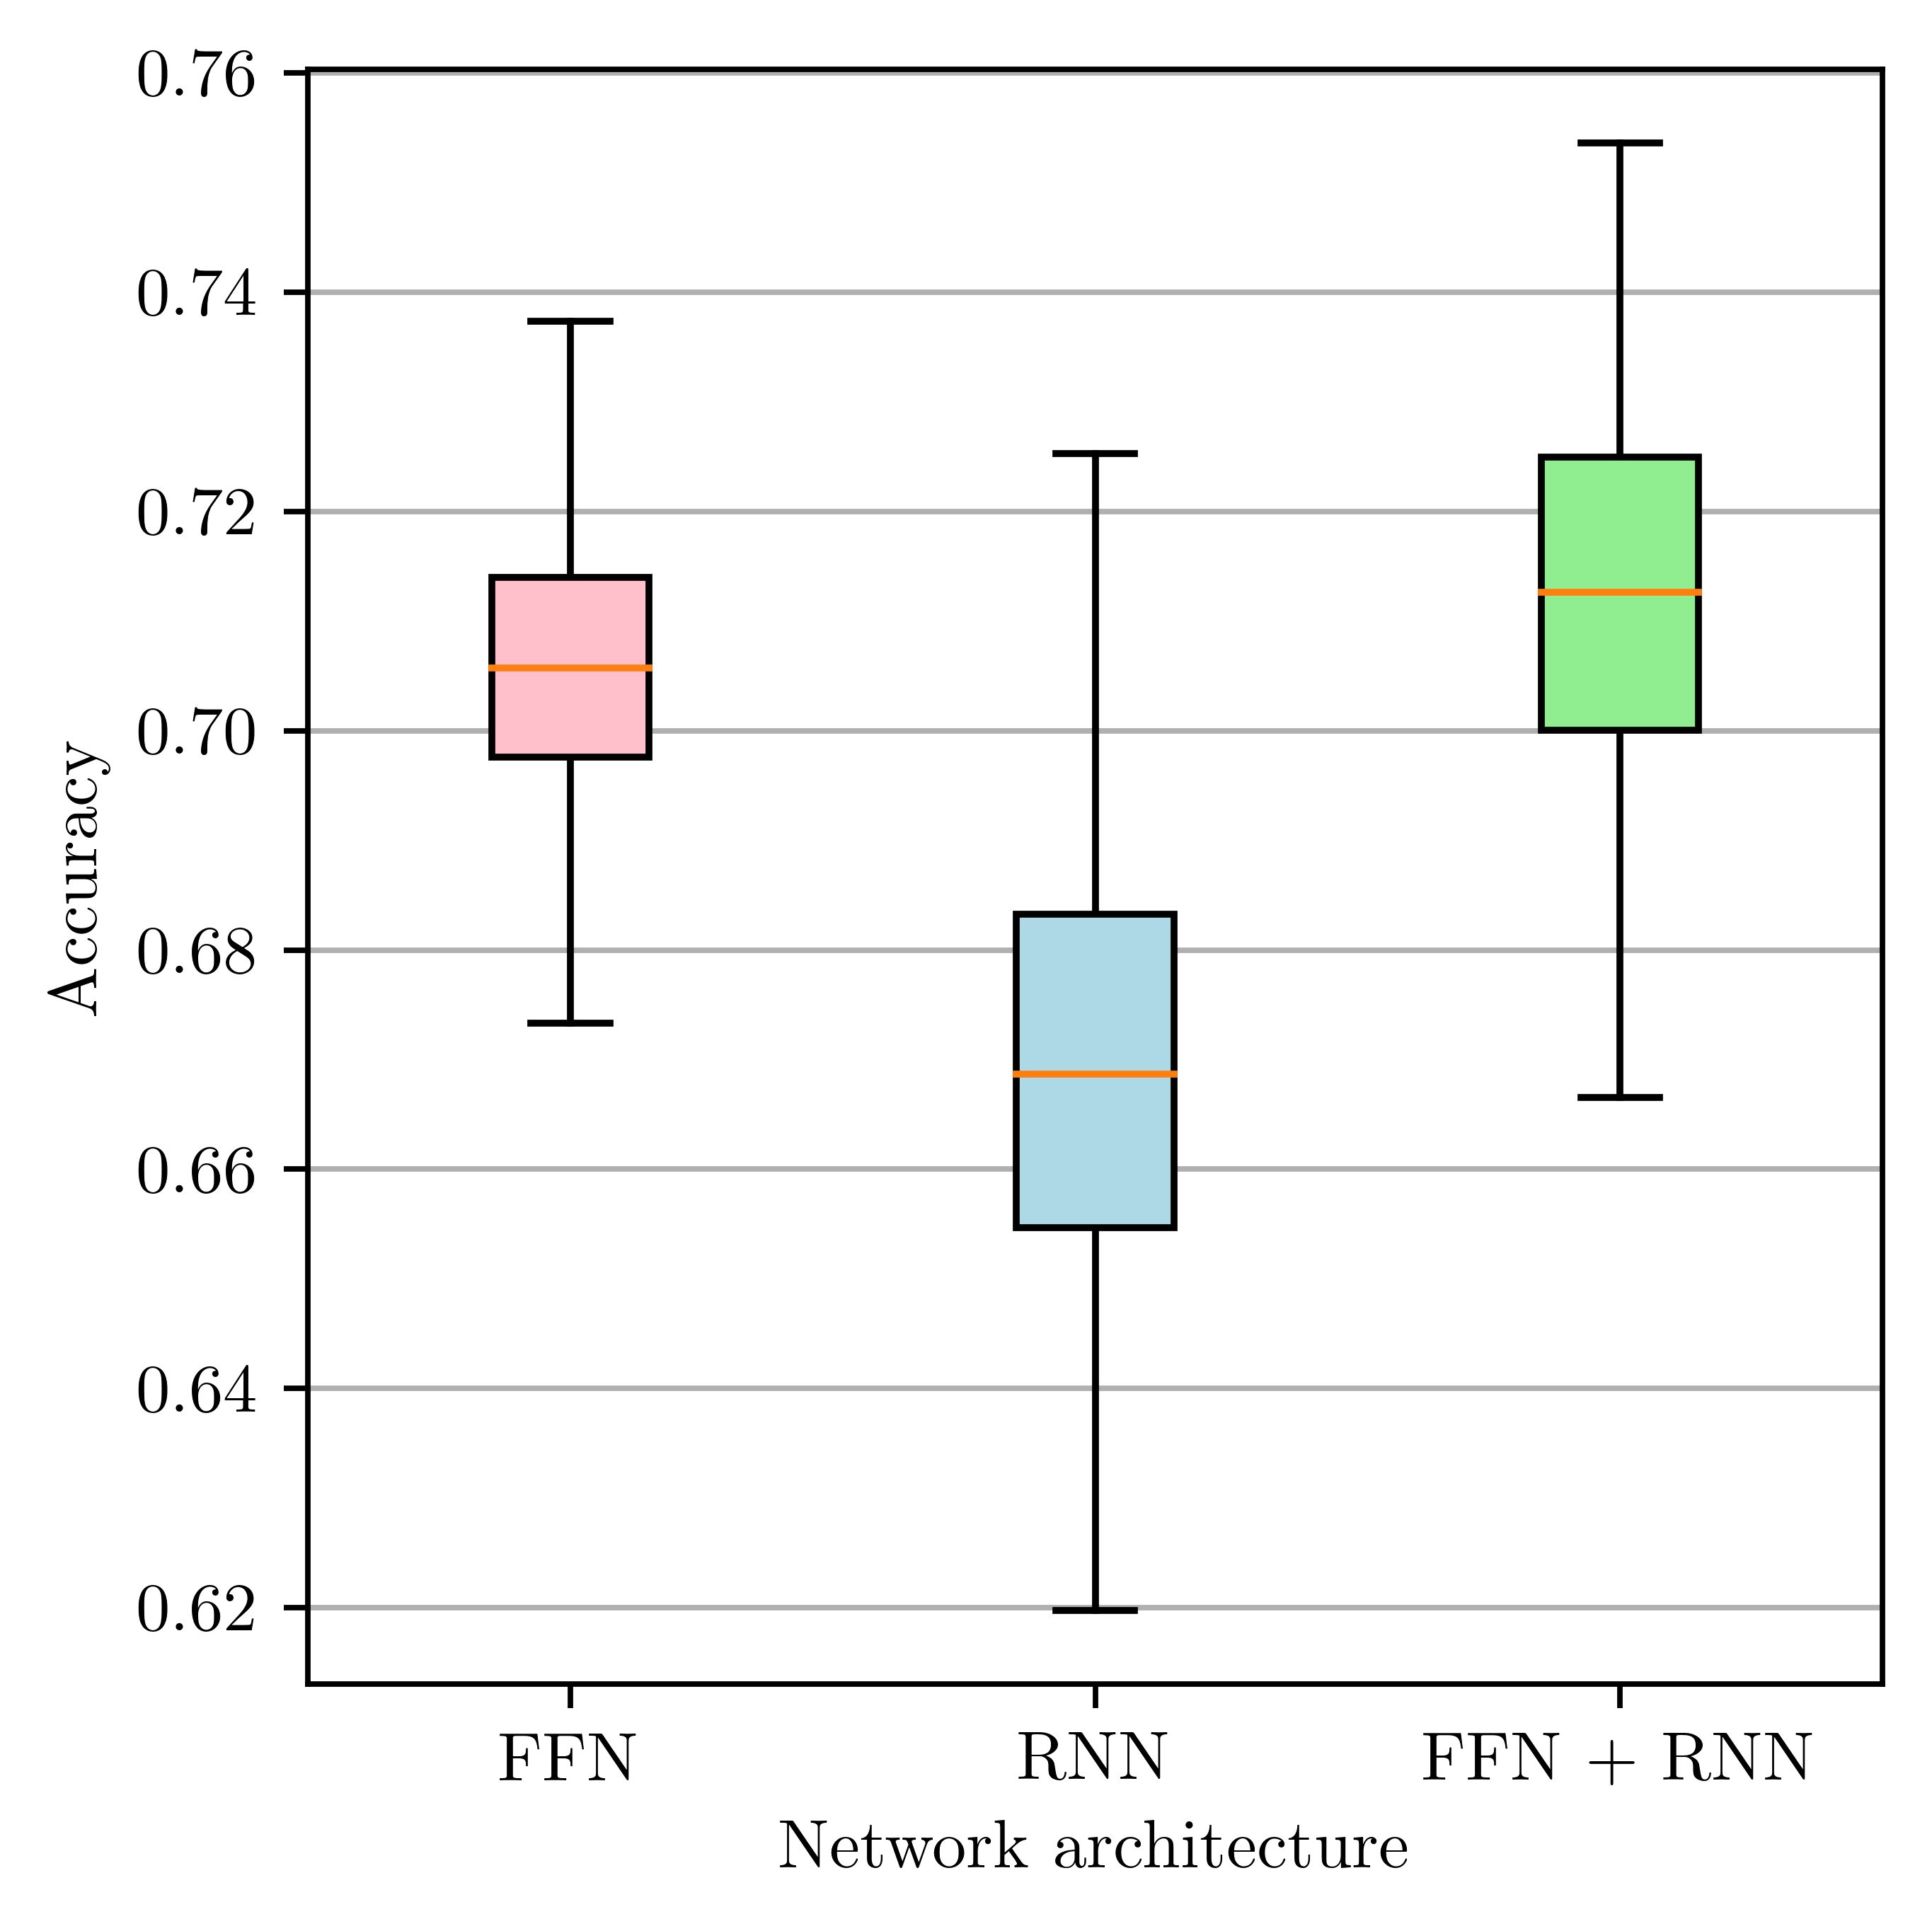

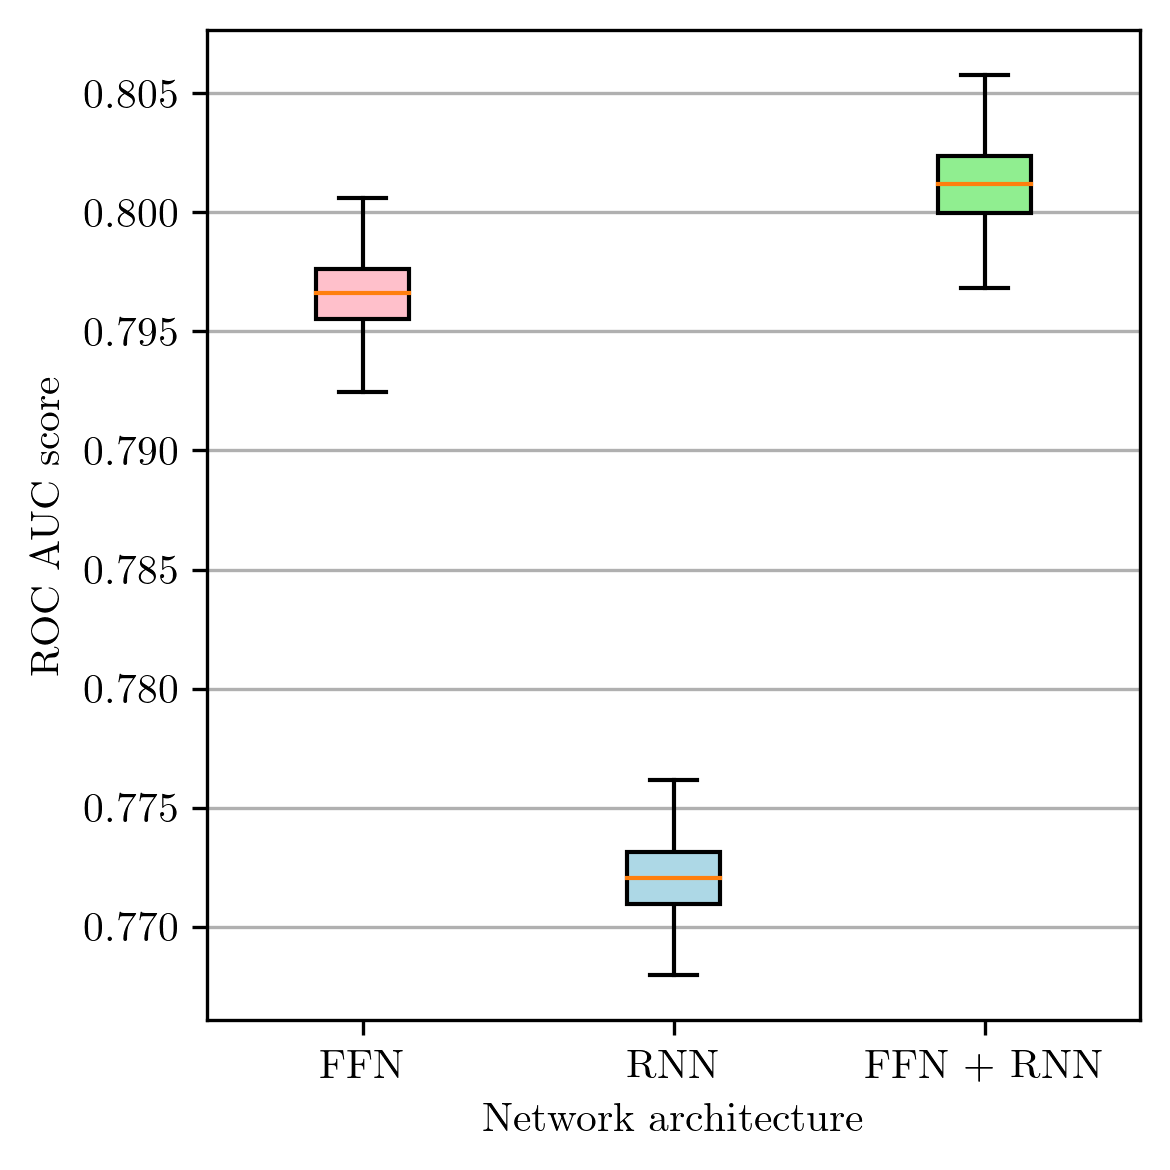

In [23]:
accuracy_results = [df.accuracy_test.to_list() for df in network_results]
roc_auc_results = [df.roc_auc.to_list() for df in network_results]
labels = ['FFN', 'RNN', 'FFN + RNN']

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig5, ax5 = plt.subplots(figsize=(4,4), dpi=700)
ax5.yaxis.grid(True)
boxplot1 = ax5.boxplot(accuracy_results, patch_artist=True, showfliers=False)
ax5.set_xticklabels(labels)
ax5.set_xlabel('Network architecture')
ax5.set_ylabel('Accuracy')

fig6,ax6 = plt.subplots(figsize=(4,4), dpi=300)
ax6.yaxis.grid(True)
boxplot2 = ax6.boxplot(roc_auc_results, patch_artist=True, showfliers=False)
ax6.set_xticklabels(labels)
ax6.set_xlabel('Network architecture')
ax6.set_ylabel('ROC AUC score')

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for bplot in (boxplot1, boxplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        
fig5.tight_layout()
fig6.tight_layout()

fig5.savefig(DIR + 'accuracy_boxplot.pdf')
fig6.savefig(DIR + 'aoc_boxplot.pdf')

In [14]:
for name, df in zip(labels, network_results):
    mean_accuracy = df.accuracy_test.mean()
    std_accuracy = df.accuracy_test.std()
    
    mean_auc_score = df.roc_auc.mean()
    std_auc_score = df.roc_auc.std()
    
    print('----------Accuracy----------')
    print('{} : {} \u00B1 {}'.format(name, mean_accuracy, std_accuracy))
    print('----------AOC score----------')
    print('{} : {} \u00B1 {}'.format(name, mean_auc_score, std_auc_score))

----------Accuracy----------
FFN : 0.7055417148168674 ± 0.011591610021830375
----------AOC score----------
FFN : 0.7966096197341709 ± 0.0015989010275551292
----------Accuracy----------
RNN : 0.6697406214451103 ± 0.020085013060335354
----------AOC score----------
RNN : 0.7720253209975277 ± 0.0016441559807979275
----------Accuracy----------
FFN + RNN : 0.7128569797339689 ± 0.017336265031172887
----------AOC score----------
FFN + RNN : 0.8011765715025577 ± 0.0018183479698341198
